In [1]:
import numpy as np
import pandas as pd 
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
!pip install seqeval
!pip install transformers
from seqeval.metrics import f1_score, accuracy_score, precision_score, recall_score

     |████████████████████████████████| 43 kB 1.8 MB/s             
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=16029ae04b190d682268da9d25c52e7ab21bb1e5dc757fcbd009d87591a55669
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [3]:
from transformers import BertModel
bert = BertModel.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
from transformers import BertTokenizerFast,BertForTokenClassification
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
tokenizer.add_tokens(['B_geo','I_geo','B_per','I_per','B_org','I_org','B_gpe','I_gpe','B_tim','I_tim','B_art','I_art','B_eve','I_eve','B_nat','I_nat'])
tokenizer

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

PreTrainedTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [5]:
data = pd.read_csv('../input/ner-data/ner.csv')

In [6]:
data.head()

,text,labels
0,Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...
1,Iranian officials say they expect to get acces...,B-gpe O O O O O O O O O O O O O O B-tim O O O ...
2,Helicopter gunships Saturday pounded militant ...,O O B-tim O O O O O B-geo O O O O O B-org O O ...
3,They left after a tense hour-long standoff wit...,O O O O O O O O O O O
4,U.N. relief coordinator Jan Egeland said Sunda...,B-geo O O B-per I-per O B-tim O B-geo O B-gpe ...


**Warning** 


In this Notebook, we will perform NER for Person,Location and Organization. So I will replace other tags with 'O' in the following funtions. If you intend to work for all the entities in the dataset, just remove the following "preprocess_dataset" function and call to it in the following line. Then again, you need to change 'label_to_ids' and 'ids_to_label' and the number of output from BERT model correspondingly. 

### data=preprocess_dataset(data)

In [8]:
unique_tags = data.labels.apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0)
unique_tags

O        887908.0
B-geo     37644.0
B-gpe     15870.0
B-tim     20333.0
B-org     20143.0
I-geo      7414.0
B-per     16990.0
I-per     17251.0
I-org     16784.0
I-tim      6528.0
B-art       402.0
I-art       297.0
B-nat       201.0
I-gpe       198.0
I-nat        51.0
B-eve       308.0
I-eve       253.0
dtype: float64

In [9]:
labels = [i.split() for i in data['labels'].values.tolist()]
unique_labels = set()

for lb in labels:
        [unique_labels.add(i) for i in lb if i not in unique_labels]
label_to_ids = {k: v for v, k in enumerate(sorted(unique_labels))}
ids_to_label = {v: k for v, k in enumerate(sorted(unique_labels))}

In [10]:
print(label_to_ids)
print(ids_to_label)

{'B-art': 0, 'B-eve': 1, 'B-geo': 2, 'B-gpe': 3, 'B-nat': 4, 'B-org': 5, 'B-per': 6, 'B-tim': 7, 'I-art': 8, 'I-eve': 9, 'I-geo': 10, 'I-gpe': 11, 'I-nat': 12, 'I-org': 13, 'I-per': 14, 'I-tim': 15, 'O': 16}
{0: 'B-art', 1: 'B-eve', 2: 'B-geo', 3: 'B-gpe', 4: 'B-nat', 5: 'B-org', 6: 'B-per', 7: 'B-tim', 8: 'I-art', 9: 'I-eve', 10: 'I-geo', 11: 'I-gpe', 12: 'I-nat', 13: 'I-org', 14: 'I-per', 15: 'I-tim', 16: 'O'}


In [11]:
def tokenize_and_preserve_labels(sentence, text_labels, tokenizer):
    """
    Word piece tokenization makes it difficult to match word labels
    back up with individual word pieces. This function tokenizes each
    word one at a time so that it is easier to preserve the correct
    label for each subword. It is, of course, a bit slower in processing
    time, but it will help our model achieve higher accuracy.
    """
    tokenized_sentence = []
    labels = []
    
    for word, label in zip(sentence, text_labels):
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)
        tokenized_sentence.extend(tokenized_word)
        labels.extend([label] * n_subwords)
    return tokenized_sentence, labels

In [12]:
label_all_tokens = True

def adjust_label(texts, labels):
    tokenized_inputs = tokenizer(texts, padding='max_length', max_length=512, truncation=True)

    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(label_to_ids[labels[word_idx]])
            except:
                label_ids.append(-100)
        else:
            try:
                label_ids.append(label_to_ids[labels[word_idx]] if label_all_tokens else -100)
            except:
                label_ids.append(-100)
        previous_word_idx = word_idx

    return label_ids

class Ner_Data(torch.utils.data.Dataset):

    def __init__(self, df):

        lb = [i.split() for i in df['labels'].values.tolist()]
        txt = df['text'].values.tolist()
        self.texts = [tokenizer(str(i), padding='max_length', max_length = 512, truncation=True) for i in txt]
        self.labels = [adjust_label(i,j) for i,j in zip(txt, lb)]

    def __len__(self):

        return len(self.labels)

    def get_batch_data(self, idx):

        return self.texts[idx]

    def get_batch_labels(self, idx):

        return torch.LongTensor(self.labels[idx])

    def __getitem__(self, idx):

        batch_data = self.get_batch_data(idx)
        batch_labels = self.get_batch_labels(idx)
        item = {key: torch.as_tensor(val) for key, val in batch_data.items()}
        item['labels'] = batch_labels
        return item


In [13]:
# data = data[:1000]
df_train, df_val, df_test = np.split(data.sample(frac=1, random_state=42),
                            [int(.8 * len(data)), int(.9 * len(data))])

In [14]:
df_train = df_train.reset_index(drop = True)
train_data = Ner_Data(df_train)
df_val = df_val.reset_index(drop = True)
val_data = Ner_Data(df_val)

In [15]:
print(df_train.iloc[10]['text'])
print(df_train.iloc[10]['labels'])
print(train_data[10]['labels'])
print((train_data[10]['input_ids']))

Officials estimate that some 5,00,000 people living in Latin American countries such as Cuba , Argentina , Mexico , Venezuela , Chile and Uruguay are eligible for citizenship .
O O O O O O O O O B-gpe O O O B-geo O B-geo O B-geo O B-geo O B-geo O B-geo O O O O O
tensor([-100,   16,   16,   16,   16,   16,   16,   16,   16,   16,   16,    3,
          16,   16,   16,    2,   16,    2,   16,    2,   16,    2,   16,    2,
          16,    2,   16,   16,   16,   16,   16, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -10

In [16]:
train_data.__getitem__(10)

{'input_ids': tensor([  101,  9018,  1116, 10301,  1115,  1199,   126,   117,  3135,   117,
          1288,  1234,  1690,  1107,  2911,  1237,  2182,  1216,  1112,  6881,
           117,  4904,   117,  2470,   117,  7917,   117,  6504,  1105, 11752,
          1132,  7408,  1111,  9709,   119,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [17]:
print(train_data[100])
print(train_data[100]['input_ids'].detach().numpy())
print(tokenizer.convert_ids_to_tokens(train_data[100]['input_ids'].detach().numpy()))
print('#####')
for i in train_data[100]['labels'].detach().numpy():
    print(i)
    print(ids_to_label.get(i))

{'input_ids': tensor([  101,  1109,   158,   119,   156,   119,  7988,  1111, 11023,  1314,
         1989,  2103,  1861,  3690,   119,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

In [18]:
train_dataloader = DataLoader(train_data, batch_size=16,shuffle=False)
val_dataloader = DataLoader(val_data, batch_size=16, shuffle=False)

In [20]:
learning_rate = 0.0001
batch_size = 16
epochs = 6

In [23]:
def train_loop(train_dataloader,val_dataloader,model, optimizer,epochs):
    size = len(train_dataloader.dataset)
    Val_loss, Train_loss = [], []
    Train_with_accuracy, Val_with_accuracy = [], []
    Train_without_accuracy, Val_without_accuracy = [], []
    for epoch_num in range(epochs):
        print(f'Epochs: {epoch_num + 1}\n-------------------------------')
        
        train_loss, train_with_accuracy, train_without_accuracy = 0, 0, 0
        train_steps = 0
        model.train()
        for idx,batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            ids= batch['input_ids'].to(device)
            mask= batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            preds = model(input_ids=ids, attention_mask=mask ,labels = labels)
    #         print(f"loss: {loss.item()}")
            loss = preds['loss']
            logits = preds['logits']
            train_loss+=loss.item()
            train_steps+=1
            # computing train accuracy
            flattened_targets = labels.view(-1) 
            active_logits = logits.view(-1, model.num_labels) 
            flattened_predictions = torch.argmax(active_logits, axis=1) 

            # computing accuracy at active labels
            labels_without = labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)

            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            tmp_train_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            train_with_accuracy += tmp_train_accuracy
            # computing accuracy at active labels excluding O
            active_without_accuracy = []
            for label in labels_without.view(-1):
                if(label == label_to_ids['O'] or label == -100):
                    active_without_accuracy.append(False)
                else:
                    active_without_accuracy.append(True)

            active_without_accuracy = torch.as_tensor(active_without_accuracy)
            active_without_accuracy = active_without_accuracy.to(device)

            labels_without = torch.masked_select(flattened_targets, active_without_accuracy)
            predictions_without = torch.masked_select(flattened_predictions, active_without_accuracy)            
            tmp_train_without_accuracy = accuracy_score(labels_without.cpu().numpy(), predictions_without.cpu().numpy())
            train_without_accuracy += tmp_train_without_accuracy

            # Backpropagation
            loss.backward()
            optimizer.step()
            if((idx+1) % 1000==0):
                print(f"Train Loss per 1000 steps: {train_loss/(idx+1):>4f} [{(idx+1):>5d}/{size/batch_size}]")
            
        model.eval()
        eval_loss, eval_with_accuracy, eval_without_accuracy = 0, 0, 0
        eval_steps = 0

        with torch.no_grad():
            for idx, batch in enumerate(val_dataloader):
                ids = batch['input_ids'].to(device, dtype = torch.long)
                mask = batch['attention_mask'].to(device, dtype = torch.long)
                labels = batch['labels'].to(device, dtype = torch.long)
                preds = model(input_ids=ids, attention_mask=mask, labels=labels)

                loss = preds['loss']
                eval_logits = preds['logits'] 
    #             print(loss.item())
                eval_loss += loss.item()
                eval_steps += 1

                if (idx+1) % 100==0:
                    loss_step = eval_loss/eval_steps
                    print(f"Validation loss per 100 evaluation steps: {loss_step}")

                # computing evaluation accuracy
                flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
                active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
                flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)

                # only compute accuracy at active labels
                labels_without = labels
                active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)

                labels = torch.masked_select(flattened_targets, active_accuracy)
                predictions = torch.masked_select(flattened_predictions, active_accuracy)

                tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
                eval_with_accuracy += tmp_eval_accuracy
       # only compute accuracy at active labels excluding O
                active_without_accuracy = []
                for label in labels_without.view(-1):
                    if(label == label_to_ids['O'] or label == -100):
                        active_without_accuracy.append(False)
                    else:
                        active_without_accuracy.append(True)

                active_without_accuracy = torch.as_tensor(active_without_accuracy)
                active_without_accuracy = active_without_accuracy.to(device)
    #             print(active_without_accuracy.size())
    #             print(flattened_targets.size())

                labels_without = torch.masked_select(flattened_targets, active_without_accuracy)
                predictions_without = torch.masked_select(flattened_predictions, active_without_accuracy)            
                tmp_eval_without_accuracy = accuracy_score(labels_without.cpu().numpy(), predictions_without.cpu().numpy())
                eval_without_accuracy += tmp_eval_without_accuracy

        train_loss = train_loss / train_steps
        train_with_accuracy = train_with_accuracy / train_steps
        train_without_accuracy = train_without_accuracy / train_steps
        Train_loss.append(train_loss)
        Train_with_accuracy.append(train_with_accuracy)
        Train_without_accuracy.append(train_without_accuracy)
        print(f"Total Train Loss: {train_loss}")
        print(f"Total Train Accuracy With O: {train_with_accuracy}")
        print(f"Total Train Accuracy Without O: {train_without_accuracy}")
        
        eval_loss = eval_loss / eval_steps
        eval_with_accuracy = eval_with_accuracy / eval_steps
        eval_without_accuracy = eval_without_accuracy / eval_steps
        Val_loss.append(eval_loss)
        Val_with_accuracy.append(eval_with_accuracy)
        Val_without_accuracy.append(eval_without_accuracy)
        print(f"Total Validation Loss: {eval_loss}")
        print(f"Total Validation Accuracy With O: {eval_with_accuracy}")
        print(f"Total Validation Accuracy Without O: {eval_without_accuracy}")
    
    item = {}
    item['train_loss'] = Train_loss
    item['val_loss'] = Val_loss
    item['train_with_acc'] = Train_with_accuracy
    item['val_with_acc'] = Val_with_accuracy
    item['train_without_acc'] = Train_without_accuracy
    item['val_without_acc'] = Val_without_accuracy
    return item
    

In [24]:
model = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(label_to_ids))
model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
results = train_loop(train_dataloader,val_dataloader, model, optimizer,epochs)

Epochs: 1
-------------------------------
Train Loss per 1000 steps: 0.269061 [ 1000/2397.9375]
Train Loss per 1000 steps: 0.226578 [ 2000/2397.9375]
Validation loss per 100 evaluation steps: 0.16732494205236434
Validation loss per 100 evaluation steps: 0.16624102910980582
Validation loss per 100 evaluation steps: 0.16483251477281252
Total Train Loss: 0.21705353971232066
Total Train Accuracy With O: 0.9336092961694766
Total Train Accuracy Without O: 0.6828501795677945
Total Validation Loss: 0.16483251477281252
Total Validation Accuracy With O: 0.9475841599314698
Total Validation Accuracy Without O: 0.7438464128409162
Epochs: 2
-------------------------------
Train Loss per 1000 steps: 0.149881 [ 1000/2397.9375]
Train Loss per 1000 steps: 0.142647 [ 2000/2397.9375]
Validation loss per 100 evaluation steps: 0.16365802075713873
Validation loss per 100 evaluation steps: 0.1625620689522475
Validation loss per 100 evaluation steps: 0.1614482051320374
Total Train Loss: 0.14045146165619152
Tot

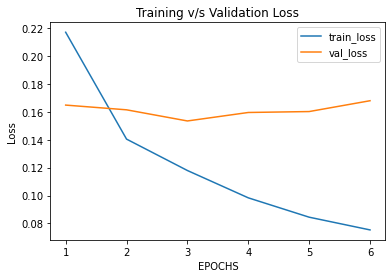

In [83]:
import matplotlib.pyplot as plt
EPOCH = np.arange(1,7)
plt.plot(EPOCH,results['train_loss'], label = 'train_loss')

plt.plot(EPOCH,results['val_loss'], label = 'val_loss')
plt.xlabel("EPOCHS")
plt.ylabel("Loss")
plt.title('Training v/s Validation Loss')
plt.legend()
plt.show()

In [128]:
test_dataset = df_test.reset_index(drop = True)
test_data = Ner_Data(test_dataset)
test_data_loader = DataLoader(test_data, batch_size=4, shuffle=False)

In [129]:
def test(model, testing_loader):
    test_loss, test_with_accuracy, test_without_accuracy = 0, 0, 0
    test_steps = 0
    test_preds, test_labels = [], []
    
    for idx, batch in enumerate(testing_loader):

        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)
        preds= model(input_ids=ids, attention_mask=mask, labels=labels)

        loss = preds['loss']
        logits = preds['logits'] 

        test_loss += loss.item()
        test_steps += 1
        # compute evaluation accuracy
        flattened_targets = labels.view(-1) 
        active_logits = logits.view(-1, model.num_labels) 
        flattened_predictions = torch.argmax(active_logits, axis=1)

        # only compute accuracy at active labels
        labels_without = labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)

        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)

        test_labels.extend(labels)
        test_preds.extend(predictions)

        tmp_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        test_with_accuracy += tmp_accuracy

        active_without_accuracy = []
        for label in labels_without.view(-1):
            if(label == label_to_ids['O'] or label == -100):
                active_without_accuracy.append(False)
            else:
                active_without_accuracy.append(True)

        active_without_accuracy = torch.as_tensor(active_without_accuracy)
        active_without_accuracy = active_without_accuracy.to(device)
#             print(active_without_accuracy.size())
#             print(flattened_targets.size())

        labels_without = torch.masked_select(flattened_targets, active_without_accuracy)
        predictions_without = torch.masked_select(flattened_predictions, active_without_accuracy)            
        tmp_without_accuracy = accuracy_score(labels_without.cpu().numpy(), predictions_without.cpu().numpy())
        test_without_accuracy += tmp_without_accuracy
            
    labels = [ids_to_label[id.item()] for id in test_labels]
    predictions = [ids_to_label[id.item()] for id in test_preds]
    test_loss = test_loss / test_steps
    test_with_accuracy = test_with_accuracy / test_steps
    test_without_accuracy = test_without_accuracy / test_steps
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_with_accuracy}")
    print(f"Test Accuracy Without O: {test_without_accuracy}")
    return labels, predictions

In [130]:
labels, predictions = test(model, test_data_loader)

Test Loss: 0.1638020795021373
Test Accuracy: 0.9603827639657017
Test Accuracy Without O: 0.815912740379854


In [131]:
from seqeval.metrics import classification_report
print(classification_report([labels], [predictions]))

              precision    recall  f1-score   support

         art       0.30      0.13      0.18        55
         eve       0.17      0.12      0.14        17
         geo       0.80      0.87      0.83      4625
         gpe       0.96      0.89      0.93      1794
         nat       1.00      0.10      0.18        50
         org       0.71      0.65      0.68      2574
         per       0.73      0.76      0.74      2271
         tim       0.83      0.83      0.83      2115

   micro avg       0.79      0.80      0.80     13501
   macro avg       0.69      0.54      0.56     13501
weighted avg       0.79      0.80      0.79     13501



In [108]:
def align_word_ids(texts):
  
    tokenized_inputs = tokenizer(texts, padding='max_length', max_length=512, truncation=True)
    word_ids = tokenized_inputs.word_ids()
    
    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(1)
            except:
                label_ids.append(-100)
        else:
            try:
                label_ids.append(1 if label_all_tokens else -100)
            except:
                label_ids.append(-100)
        previous_word_idx = word_idx

    return label_ids


def evaluate_one_text(model, sentence):
    text_input = tokenizer(sentence, padding='max_length', max_length = 512, truncation=True)
    text = tokenizer(sentence, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")
    mask = text['attention_mask'].to(device)
    input_id = text['input_ids'].to(device)
    label_ids = torch.Tensor(align_word_ids(sentence)).unsqueeze(0).to(device)

    logits = model(input_id, mask, None)
    logits_clean = logits[0][label_ids != -100]

    predictions = logits_clean.argmax(dim=1).tolist()
    prediction_label = [ids_to_label[i] for i in predictions]
    text_tokens = tokenizer.convert_ids_to_tokens(text_input['input_ids'])
    
    print(sentence)
    print("Tokenized Sentence:",text_tokens[1:text_tokens.index('[SEP]')])
    print("Predicted Labels:",prediction_label)
            
evaluate_one_text(model, 'Sundar Pichai is the CEO of Google .')


Sundar Pichai is the CEO of Google .
Tokenized Sentence: ['Sun', '##dar', 'Pi', '##cha', '##i', 'is', 'the', 'CEO', 'of', 'Google', '.']
Predicted Labels: ['B-per', 'B-per', 'I-per', 'I-per', 'I-per', 'O', 'O', 'O', 'O', 'B-org', 'O']


## SAVING THE MODEL

In [39]:
torch.save(model, './model.pth')

In [40]:
# model3 = torch.load('./model.pth')